<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/fft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
- benchmark FFT vs naive DFT
- to build intuition about indexing in `np.fft` (changed with `np.fft.fftshift`)

# Resources
* https://towardsdatascience.com/fast-fourier-transform-937926e591cb
* Ziegel, E., Press, W., Flannery, B., Teukolsky, S., & Vetterling, W. (1992). Numerical Recipes: The Art of Scientific Computing (2nd ed.). Cambridge University Press.
  * Chapter 12: Fast Fourier Transform
    * 12.2 Fast Fourier Transform (FFT)

# Setup

In [2]:
import numpy as np
import pandas as pd
import collections


# DFT


In [131]:
def dft_setup(N):
  n = np.arange(N)
  k = n.reshape((N,1))
  W = np.exp(-2j*np.pi/N * n * k) # makes into NxN matrix becaue of shapes of n and k. see eq 12.2.1, 12.2.2 in Numerical Receipies in C
  return(W)

def make_gauss(n):

  std = 1
  x_dom = np.linspace(-30*std,30*std,2**n) # important that size is 2^n for recursive nature of divide and conquor
  x = np.exp(-x_dom**2/(2*std**2))
  return(x)

x = make_gauss(n=10)
N = x.shape[0]
W = dft_setup(N)

def do_dft(W,x):
  return(np.dot(W,x))

In [38]:
np.allclose(do_dft(W,x), np.fft.fft(x))
error = np.abs(do_dft(W,x) - np.fft.fft(x))
(error**2).mean(), error.max()

(5.214423304270279e-24, 3.269842392808019e-11)

The error is very small

In [58]:
%timeit dft_setup(N)
%timeit do_dft(W,x)
%timeit np.fft.fft(x)

10 loops, best of 3: 76.8 ms per loop
1000 loops, best of 3: 631 µs per loop
The slowest run took 4.49 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 17.8 µs per loop


The runtime is faster for `np.fft.fft`, and the bottleneck for our `do_dft` is the data-independent (but `N` dependent) setup we need to run it.

The FT of a gaussian should be a gaussian, so we see below that the centering is shifted.

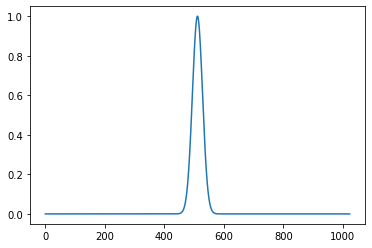

In [56]:
pd.Series(x).plot() # origin assumed to be the centre

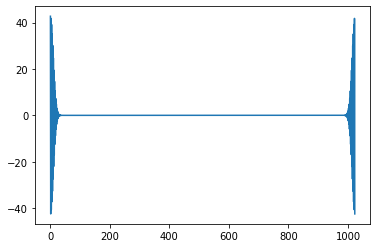

In [57]:
pd.Series(do_dft(W,x).real).plot() # this computation assumed the origin was the first index

# Recursion
the $N\log(N)$ versus $N^2$ speedup of the FFT can be seen through considering the recursive way of splitting the sums into even and odd terms, which can be repeated. The $N=2^n$ size is important for the recursion to do all the way down.

In [71]:
def recursive_fft(x):
# https://towardsdatascience.com/fast-fourier-transform-937926e591cb
  N = x.shape[0]
  #assert N % 2 > 0 # can check outside function
  if N <= 2:
    W = dft_setup(N)
    return(do_dft(W,x))
  else:
    X_even = recursive_fft(x[::2])
    X_odd = recursive_fft(x[1::2])
    W = np.exp(-2j*np.pi*np.arange(N)/N) # could be precomputed
    fft = np.concatenate([X_even + W[:int(N/2)] * X_odd,
                          X_even + W[int(N/2):] * X_odd])
    return(fft)




In [86]:
N = x.shape[0]
assert np.isclose(np.log2(N) % 1,0) # fails if not power of 2
np.allclose(recursive_fft(x),np.fft.fft(x))

True

In [79]:
W = dft_setup(N)
%timeit dft_setup(N)
%timeit do_dft(W,x)
%timeit recursive_fft(x)
%timeit np.fft.fft(x)

10 loops, best of 3: 77.8 ms per loop
1000 loops, best of 3: 638 µs per loop
100 loops, best of 3: 11.5 ms per loop
The slowest run took 4.49 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 18.2 µs per loop


`do_dft` needs `dft_setup`, so we should add their time together. `recursive_fft` is an improvement, since the setup size is much smaller. But the winner is still clearly `np.fft.fft`

# Vectorized
instead of recursion, we can vectorize things with a `while` loop, splitting even and odd terms by column, iteratively building up rows in the loop

In [124]:
def vec_fft(x):
  W = dft_setup(2)
  X = np.dot(W,x.reshape(2,-1))
  while X.shape[0] < N: # builds up
    X_even = X[:,:int(X.shape[1] / 2)] # first half 
    X_odd = X[:,int(X.shape[1] / 2):] # second half 
    terms = np.exp(-1j * np.pi * np.arange(X.shape[0]) / X.shape[0])[:, None]
    X = np.vstack([X_even + terms * X_odd,
                          X_even - terms * X_odd])
  return(X.ravel())
    

In [125]:
np.allclose(vec_fft(x), np.fft.fft(x))

True

In [130]:
W = dft_setup(N)
%timeit dft_setup(N)
%timeit do_dft(W,x)
%timeit vec_fft(x)
%timeit np.fft.fft(x)

10 loops, best of 3: 78.4 ms per loop
1000 loops, best of 3: 734 µs per loop
1000 loops, best of 3: 370 µs per loop
The slowest run took 5.48 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 18.1 µs per loop


`vec_fft` is bit faster than `do_dft`, which has a large `np.dot`, but perhaps this is just due to caching. 

# Benchmark runtime vs. N
$N\log(N)$
We can run the functions at varoius sizes of $N$ and compare how they scale

In [ ]:
d = collections.defaultdict(list)
ns = [6,7,8,9,10]

for n in ns:

  x = make_gauss(n=n)
  N = x.shape[0]
  d['N'].append(N)
  W = dft_setup(N) # don't include in computation
  res = %timeit -o np.fft.fft(x)
  d['np.fft.fft'].append(res.best*1e6)
  res = %timeit -o do_dft(W,x)
  d['do_dft'].append(res.best*1e6)
  res = %timeit -o vec_fft(x)
  d['vec_fft'].append(res.best*1e6)

df = pd.DataFrame(d)



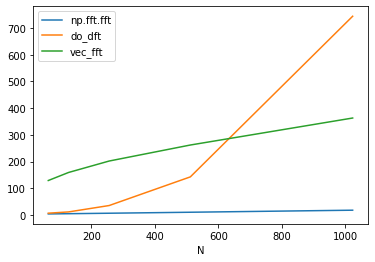

In [172]:
df.plot(x='N',y=['np.fft.fft','do_dft','vec_fft'])
